Missing Values in Fraud Data:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
Missing Values in Credit Card Data:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Missing Values in IP to Country:
 lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64
Credit Card Data Shape after removing duplicates: (283726, 31)


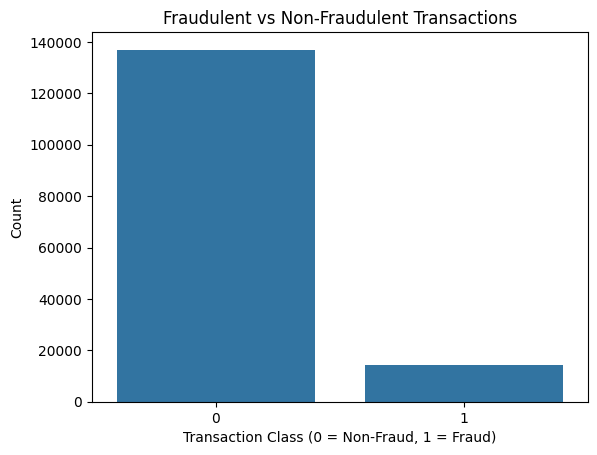

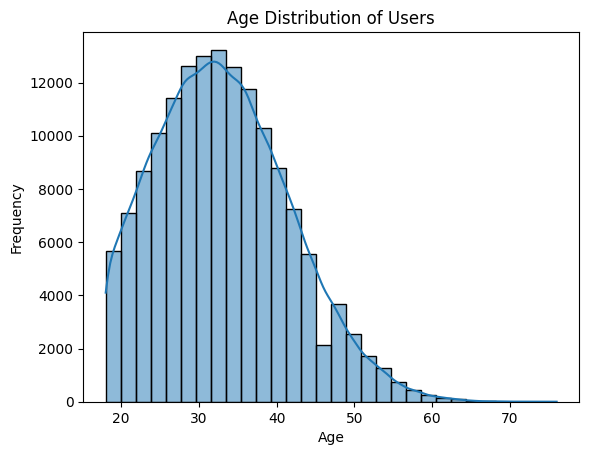

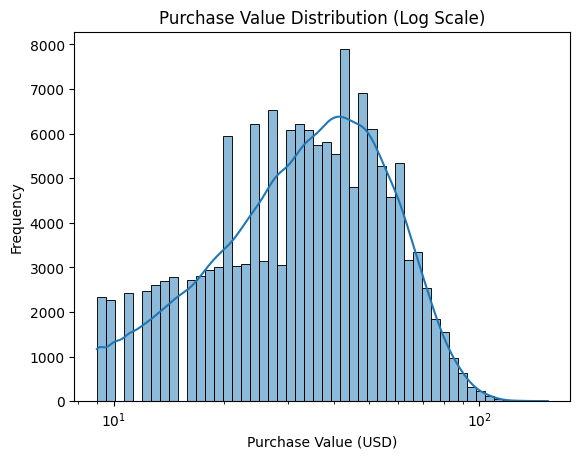

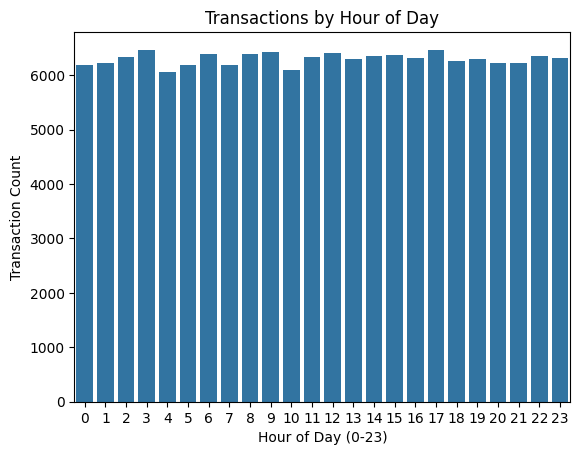

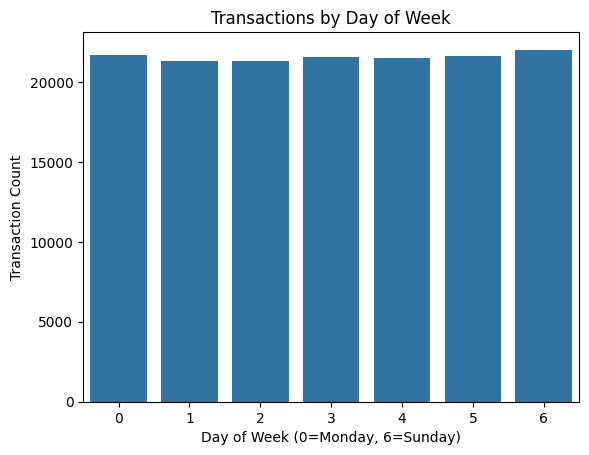

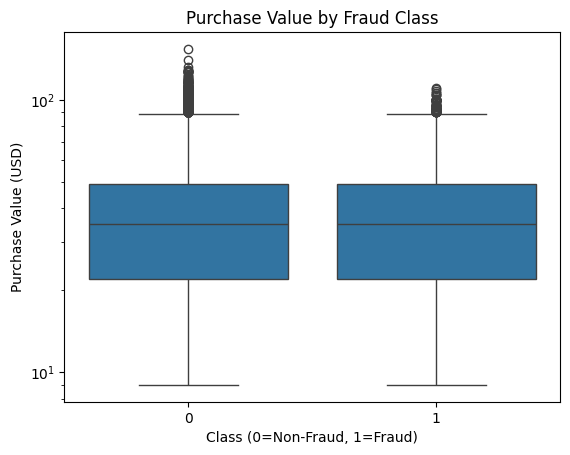

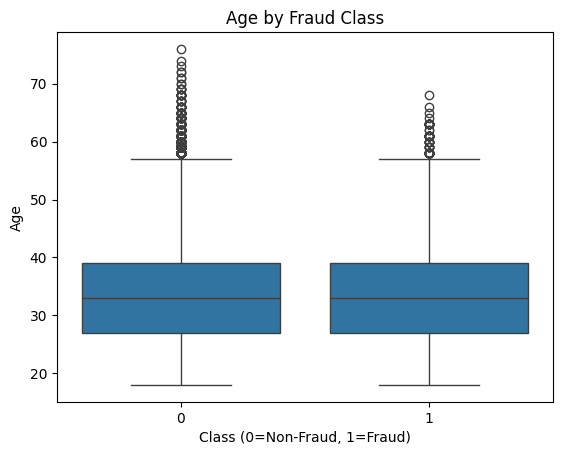

Class distribution after SMOTE:
 class
0    136961
1    136961
Name: count, dtype: int64
Shape of scaled feature set: (273922, 12)


In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE


# Load Data
fraud_data = pd.read_csv('../data/Fraud_Data.csv')
ip_country = pd.read_csv('../data/IpAddress_to_Country.csv')
credit_card_data = pd.read_csv('../data/creditcard.csv')


# 1. Handle Missing Values
print("Missing Values in Fraud Data:\n", fraud_data.isnull().sum())
print("Missing Values in Credit Card Data:\n", credit_card_data.isnull().sum())
print("Missing Values in IP to Country:\n", ip_country.isnull().sum())


# 2. Data Cleaning
# Drop duplicates in Credit Card Data
credit_card_data.drop_duplicates(inplace=True)
print("Credit Card Data Shape after removing duplicates:", credit_card_data.shape)

# Convert signup_time and purchase_time to datetime
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])


# 3. Exploratory Data Analysis (EDA)

# Class distribution
sns.countplot(x='class', data=fraud_data)
plt.title('Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Transaction Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.show()

# Age distribution
sns.histplot(fraud_data['age'], bins=30, kde=True)
plt.title('Age Distribution of Users')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Purchase value distribution (log scale)
sns.histplot(fraud_data['purchase_value'], bins=50, kde=True, log_scale=True)
plt.title('Purchase Value Distribution (Log Scale)')
plt.xlabel('Purchase Value (USD)')
plt.ylabel('Frequency')
plt.show()

# Transactions by Hour of Day
sns.countplot(x='hour_of_day', data=fraud_data.assign(hour_of_day=fraud_data['purchase_time'].dt.hour))
plt.title('Transactions by Hour of Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Transaction Count')
plt.show()

# Transactions by Day of Week
sns.countplot(x='day_of_week', data=fraud_data.assign(day_of_week=fraud_data['purchase_time'].dt.dayofweek))
plt.title('Transactions by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Transaction Count')
plt.show()

# Purchase Value by Fraud Class
sns.boxplot(x='class', y='purchase_value', data=fraud_data)
plt.title('Purchase Value by Fraud Class')
plt.xlabel('Class (0=Non-Fraud, 1=Fraud)')
plt.ylabel('Purchase Value (USD)')
plt.yscale('log')
plt.show()

# Age by Fraud Class
sns.boxplot(x='class', y='age', data=fraud_data)
plt.title('Age by Fraud Class')
plt.xlabel('Class (0=Non-Fraud, 1=Fraud)')
plt.ylabel('Age')
plt.show()


# 4. Merge Datasets for Geolocation Analysis
# Create IntervalIndex from IP ranges
ip_intervals = pd.IntervalIndex.from_arrays(
    ip_country['lower_bound_ip_address'],
    ip_country['upper_bound_ip_address'],
    closed='both'
)

# Function to map IP to country
def get_country(ip):
    idx = ip_intervals.get_indexer([ip])[0]
    if idx == -1:
        return 'Unknown'
    else:
        return ip_country.iloc[idx]['country']

# Map countries
fraud_data['country'] = fraud_data['ip_address'].apply(get_country)


# 5. Feature Engineering
# Add transaction counts (if user_id/device_id exist)
if 'user_id' in fraud_data.columns and 'device_id' in fraud_data.columns:
    fraud_data['user_tx_count'] = fraud_data.groupby('user_id')['purchase_time'].transform('count')
    fraud_data['device_tx_count'] = fraud_data.groupby('device_id')['purchase_time'].transform('count')
    fraud_data.drop(['user_id', 'device_id'], axis=1, inplace=True)

# Time-based features
fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek
fraud_data['time_since_signup'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds()

# Label encode categorical columns
categorical_cols = ['browser', 'source', 'sex', 'country']
le = LabelEncoder()
for col in categorical_cols:
    fraud_data[col] = le.fit_transform(fraud_data[col])

# Drop datetime columns
fraud_data.drop(['signup_time', 'purchase_time'], axis=1, inplace=True)


# 6. Data Transformation (SMOTE + Scaling)
X_fraud_prepared = fraud_data.drop('class', axis=1)
y_fraud = fraud_data['class']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_fraud_prepared, y_fraud)

print("Class distribution after SMOTE:\n", pd.Series(y_resampled).value_counts())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

print("Shape of scaled feature set:", X_scaled.shape)

In [3]:
# Task 2 - Model Building and Training

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, average_precision_score, confusion_matrix, classification_report

# ---- Load Preprocessed and Scaled Data from Task 1 ----
X_fraud_scaled = pd.read_csv("../data/Fraud_Data.csv")
X_fraud = X_scaled 

y_fraud = y_resampled

# Split into train and test
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud)

#  Model Evaluation Function 
def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"--- {name} Evaluation ---")
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC-PR:", average_precision_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("\n")

#  Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
evaluate_model(log_reg, Xf_train, Xf_test, yf_train, yf_test, "Logistic Regression - Fraud")

#  Random Forest Classifier 
rf = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf, Xf_train, Xf_test, yf_train, yf_test, "Random Forest - Fraud")

--- Logistic Regression - Fraud Evaluation ---
F1 Score: 0.7650335970060389
AUC-PR: 0.7732753674776986
Confusion Matrix:
 [[25746  1647]
 [ 9403 17989]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.94      0.82     27393
           1       0.92      0.66      0.77     27392

    accuracy                           0.80     54785
   macro avg       0.82      0.80      0.79     54785
weighted avg       0.82      0.80      0.79     54785



--- Random Forest - Fraud Evaluation ---
F1 Score: 0.8995932509792106
AUC-PR: 0.8740743946406335
Confusion Matrix:
 [[25567  1826]
 [ 3506 23886]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91     27393
           1       0.93      0.87      0.90     27392

    accuracy                           0.90     54785
   macro avg       0.90      0.90      0.90     54785
weighted avg       0.90      0.90      0.90     547

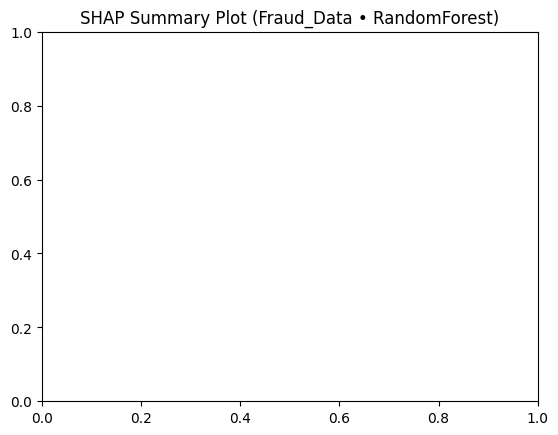

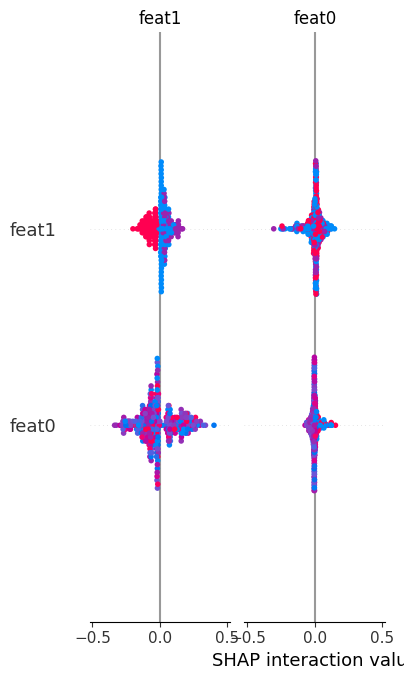

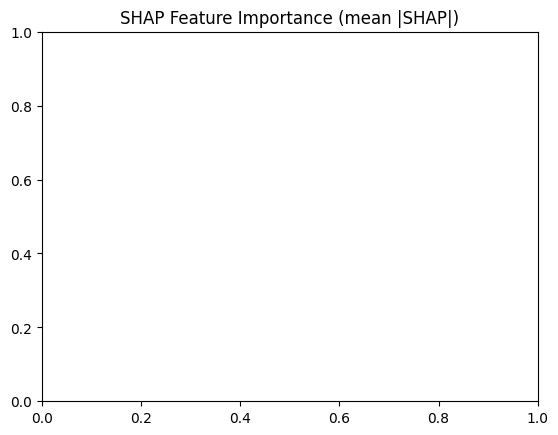

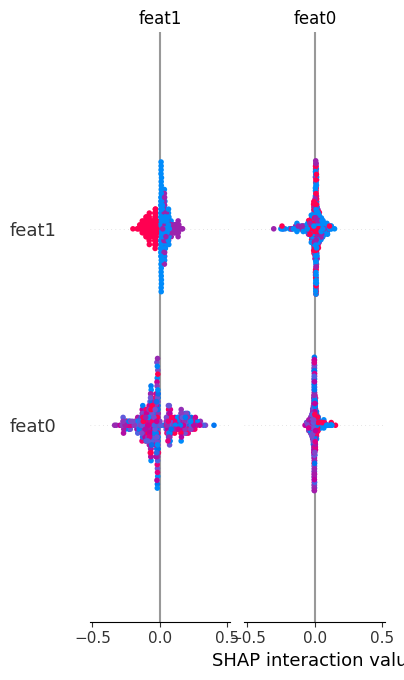

c:\Users\Bereket\Documents\Tenx\Week 8\fraud-detection\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


IndexError: index 17 is out of bounds for axis 0 with size 12

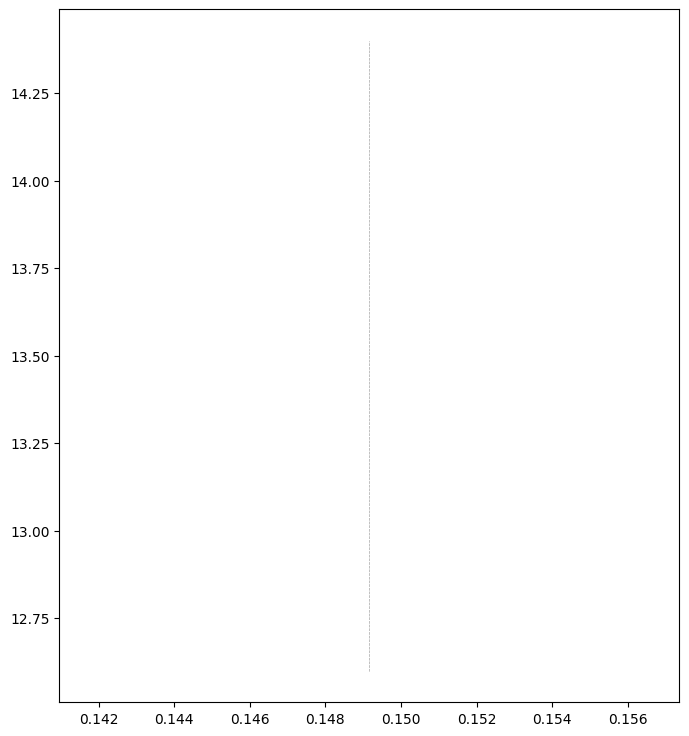

In [8]:
# =============================
# Task 3: Model Explainability with SHAP (Fraud_Data + RandomForest)
# =============================

# 1) Install & import SHAP safely
try:
    import shap
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ---------- Helpers ----------
def to_frame(X, like_df=None, name_prefix="f"):
    """
    Ensure X is a pandas DataFrame with column names.
    If `like_df` provided and shapes match, reuse its column names.
    Otherwise create generic names f0..f{n-1}.
    """
    if isinstance(X, pd.DataFrame):
        return X.copy()
    n_features = X.shape[1]
    if isinstance(like_df, pd.DataFrame) and like_df.shape[1] == n_features:
        cols = list(like_df.columns)
    else:
        cols = [f"{name_prefix}{i}" for i in range(n_features)]
    return pd.DataFrame(X, columns=cols)

def get_pos_shap_and_base(shap_vals, expected_value):
    """
    Returns (shap_values_for_positive_class, expected_value_for_positive_class)
    Works with both old (list) and new (array) SHAP outputs.
    """
    if isinstance(shap_vals, list):
        pos_vals = shap_vals[1]
        base = expected_value[1] if isinstance(expected_value, (list, np.ndarray)) else expected_value
    else:
        pos_vals = shap_vals
        if isinstance(expected_value, (list, np.ndarray)) and len(np.atleast_1d(expected_value)) > 1:
            base = np.atleast_1d(expected_value)[1]
        else:
            base = expected_value
    return pos_vals, base

# ---------- Use your trained model & test split from Task 2 ----------
try:
    best_model = rf  # your RandomForest from Task 2
except NameError:
    raise NameError("RandomForest model variable `rf` not found. Make sure Task 2 defined it.")

if 'Xf_test' not in globals():
    raise NameError("`Xf_test` not found. Make sure Task 2 created Xf_test / yf_test.")

# Try to pull column names from any Fraud_Data DataFrame you may still have (optional)
like_df = None
for candidate in ['X_fraud_scaled', 'X_fraud', 'Xf_train', 'Xf_test']:
    if candidate in globals() and isinstance(globals()[candidate], pd.DataFrame):
        like_df = globals()[candidate]
        break

Xf_test_df = to_frame(Xf_test, like_df=like_df, name_prefix="feat")
Xf_train_df = to_frame(Xf_train, like_df=like_df, name_prefix="feat") if 'Xf_train' in globals() else None

# Use a manageable sample for global plots (faster)
X_sample = Xf_test_df.sample(min(400, len(Xf_test_df)), random_state=42).copy()

# ---------- Build the SHAP explainer ----------
# TreeExplainer is appropriate for RandomForest/GBMs
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_sample)
pos_shap_values, pos_base_value = get_pos_shap_and_base(shap_values, explainer.expected_value)

# =============================
# Global Interpretability
# =============================

# 1) SHAP Summary Plot (beeswarm) — top features & direction of impact
plt.title("SHAP Summary Plot (Fraud_Data • RandomForest)")
shap.summary_plot(pos_shap_values, X_sample, show=True)

# 2) SHAP Bar Plot — mean absolute SHAP values (global importance ranking)
plt.title("SHAP Feature Importance (mean |SHAP|)")
shap.summary_plot(pos_shap_values, X_sample, plot_type="bar", show=True)

# =============================
# Local Interpretability (single transaction) — FIXED
# =============================

# Pick the highest-probability fraud example in the FULL test set
proba_test = best_model.predict_proba(Xf_test_df)[:, 1]
top_idx = int(np.argmax(proba_test))
x_one = Xf_test_df.iloc[[top_idx]]  # keep as DataFrame

# SHAP values for the single instance
shap_one = explainer.shap_values(x_one)
pos_shap_one, pos_base_one = get_pos_shap_and_base(shap_one, explainer.expected_value)

# ---- Use Waterfall (robust single-sample explanation)
# Build a SHAP Explanation object (works across SHAP versions)
vals_1d = np.array(pos_shap_one).reshape(-1)            # flatten to 1D
feat_vals = x_one.iloc[0, :].values
feat_names = x_one.columns

try:
    exp = shap.Explanation(values=vals_1d,
                           base_values=pos_base_one,
                           data=feat_vals,
                           feature_names=feat_names)
    # Newer API
    shap.plots.waterfall(exp, max_display=15)
except Exception:
    # Older API fallback
    from shap.plots._waterfall import waterfall
    exp = shap.Explanation(values=vals_1d,
                           base_values=pos_base_one,
                           data=feat_vals,
                           feature_names=feat_names)
    waterfall(exp, max_display=15)

# ---- Decision plot (still helpful)
shap.decision_plot(
    pos_base_one,
    pos_shap_one if pos_shap_one.ndim == 2 else pos_shap_one.reshape(1, -1),
    x_one,
    feature_display_range=slice(None, 15)
)

print("✅ Local explanations generated via Waterfall and Decision plots.")

print("✅ Task 3 complete: Global (summary, bar) and Local (force, decision) SHAP plots generated.")